# Scaling Analysis Examples TTbar70

Authors: Brain Gravelle and Boyana Norris


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/

<a href='#top'>top</a><br>
<a href='#data'>Loading Data</a><br>
<a href='#metrics'>Metrics</a><br>
<a href='#corr'>Correlations</a><br>
<a href='#stl_sb'>Store Buffer Stalls</a><br>
<a href='#fetch_stalls'>Fetch Stalls</a><br>
<a href='#l3'>l3 misses</a><br>

## Imports
This section imports necessary libraies, the metrics.py and utilities.py files and sets up the window.


<a id='top'></a>

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import copy, shelve

## Getting Data
<a id='data'></a>

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit. The first six experiments use the --num-thr option to set the thread count which is intended to perform threading within the events. the last two add the --num-ev-thr option to set the event threads, so that all threads are used to process events in parallel and each event is processed by a single thread. 
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings (quad - 1 NUMA domain, cache - MCDRAM as direct mapped cache). See http://www.nersc.gov/users/computational-systems/cori/running-jobs/advanced-running-jobs-options/ for more info on the KNL modes. Similar to the talapas scaling they use the build-ce option and threading within each event.
* manual_scaling_TTbar35
* manual_scaling_TTbar70
* manual_scaling_Large

Of interest to this notebook are the following:
* cori_scaling_old, manual_scaling_TTbar70 - a version of based on the original code
* pr141_scaling, manual_scaling_TTbar70 - a version of based on the code after analysis of the original
* cori_latest_scaling, manual_scaling_TTbar70 - a version of based on the code several weeks later

All of these were conducted on Cori as described above.



### Importing Scaling Data - Talapas TTbar70 is current
Here we import the data. In this case we are using Cori data from the experiments with the threads working within each event using the TTbar70 file. This function will first attempt to import compressed versions of the data and if unable to do that will then use the originals.

In [2]:
application1 = "cori_scaling_old"
application2 = "pr141_scaling"
application3 = "cori_latest_scaling"

experiment  = "manual_scaling_TTbar70"

original_metric_data = load_perf_data(application1,experiment,nolibs=False,scaling=True,callpaths=True)
original_metric_data = remove_erroneous_threads(original_metric_data,  [4, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

# pr141_metric_data = load_perf_data(application2,experiment,nolibs=False,scaling=True,callpaths=True)
# pr141_metric_data = remove_erroneous_threads(pr141_metric_data,  [4, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

It would seem that all the metrics didn't make it for all thread counts

In [4]:
#metric_data_talapas_manual_scaling_TTbar70_talapas_fullnode = metric_data
#metric_data_cori_manual_scaling_TTbar70=metric_data
print original_metric_data[4].keys()
print original_metric_data[8].keys()
print original_metric_data[112].keys()

KeyError: 4

## Adding metrics
<a id='metrics'></a>

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

Here we add some predeefined metrics and print the top 10 functions with the best IPC

In [4]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_IPC)
add_metric_to_scaling_data(metric_data, add_StallPercent)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_VIPC)
#add_metric_to_scaling_data(metric_data, add_DERIVED_SP_VOPO)

if application == 'cori_scaling': 
    llc = True
    add_metric_to_scaling_data(metric_data, add_VIPI)
else: 
    llc = False
#     add_metric_to_scaling_data(metric_data, add_DERIVED_SP_VOPO)
    
add_metric_to_scaling_data(metric_data, add_L3_missrate, llc)
add_metric_to_scaling_data(metric_data, add_DERIVED_BRANCH_MR)

print_available_metrics(metric_data, scaling=True)
print(metric_data.keys())
# To test
# metric_data[32]['DERIVED_SP_VOPO'].sort_values(by='Exclusive',ascending=False).head(10)

ERROR adding CPI to metric dictionary
ERROR adding CPI to metric dictionary
ERROR adding CPI to metric dictionary
ERROR adding CPI to metric dictionary
ERROR adding metric to thread count: 240
ERROR adding metric to thread count: 4
ERROR adding metric to thread count: 192
ERROR adding metric to thread count: 208
ERROR adding IPC to metric dictionary
ERROR adding IPC to metric dictionary
ERROR adding IPC to metric dictionary
ERROR adding IPC to metric dictionary
ERROR adding metric to thread count: 240
ERROR adding metric to thread count: 4
ERROR adding metric to thread count: 192
ERROR adding metric to thread count: 208
ERROR adding StallPercent to metric dictionary
ERROR adding StallPercent to metric dictionary
ERROR adding StallPercent to metric dictionary
ERROR adding StallPercent to metric dictionary
ERROR adding metric to thread count: 240
ERROR adding metric to thread count: 4
ERROR adding metric to thread count: 192
ERROR adding metric to thread count: 208
ERROR adding L1 MR to 

#### Combining metrics

In [5]:
THREAD_COUNT = 256

alldata = combine_metrics(metric_data[THREAD_COUNT],inc_exc='Exclusive')
alldata.head()

PAPI_TOT_CYC  \
thread region                                                                                 
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...      6.25e+06   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...      7.99e+05   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...      2.00e+07   
       [SUMMARY] .TAU application                                                  0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                   0.00e+00   

                                                                               PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD  \
thread region                                                                                                         
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...                                   nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...                              5.81e+03   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...                              1.27e+06   
       [SUMMARY] .TAU application                                                                          0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                                           0.00e+00   

                                                                               PAPI_L2_TCA  \
thread region                                                                                
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...          nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...          nan   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...     1.36e+05   
       [SUMMARY] .TAU application                                                 0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                  0.00e+00   

                                                                               PAPI_NATIVE_LLC_MISSES  \
thread region                                                                                           
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...                     nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...                1.84e+04   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...                1.58e+04   
       [SUMMARY] .TAU application                                                            0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                             0.00e+00   

                                                                               DERIVED_VIPC  \
thread region                                                                                 
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...           nan   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...      3.34e+00   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...           nan   
       [SUMMARY] .TAU application                                                       nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                        nan   

                                                                               PAPI_L2_TCM  \
thread region                                                                                
0      [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Mat...     6.30e+03   
       [SUMMARY] (anonymous namespace)::MultHelixPropTranspEndcap(Matriple...          nan   
       [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...     9.02e+03   
       [SUMMARY] .TAU application               

## Scaling Results

In this section we carefully walk through an analysis of the application to find areas of interest.

We begin by looking at correlations of data to determine metrics of interest and then move on to ploting those metric. In this analysis we primarily use PAPI_TOT_CYC as a proxy for the time it takes a function to complete.

## Correlations
<a id='corr'></a>

In [6]:
names={'PAPI_TOT_CYC':'Total Cycles',
'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD':'Vector operations',
'PAPI_L2_TCA' : 'L2 accesses',
'PAPI_NATIVE_LLC_MISSES' : 'L3 total cache misses',
'PAPI_NATIVE_LLC_REFERENCES' : 'L3 accesses',
'PAPI_TLB_DM' : 'TLB data misses',
'PAPI_BR_MSP' : 'Branch mispredictions',
'PAPI_L1_TCM' : 'L1 total cache misses',
'PAPI_L2_TCM' : 'L2 total cache misses',
'PAPI_LST_INS' : 'Load/store instructions',
'PAPI_BR_CN' : 'Conditional branches',
'PAPI_TOT_INS' : 'Total instructions',
'PAPI_BR_INS' : 'Branch instructions',
'PAPI_BR_UCN' : 'Unconditional branches',
'PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD' : 'Scalar vector ops',
'PAPI_RES_STL' : 'Total resource stalls (cycles)',
'PAPI_NATIVE_FETCH_STALL':'Number of cycles stalled for instruction cache miss',
'PAPI_NATIVE_RS_FULL_STALL' : 'Resource stalls',
'DERIVED_STALL_PERCENT' : 'Fraction of total stalls',
'DERIVED_L1_MISSRATE' : 'L1 miss rate',
'DERIVED_L3_MISSRATE' : 'L3 miss rate',
'DERIVED_BRANCH_MR' : 'Branch misprediction rate',
'DERIVED_IPC' : 'Instructions per cycle',
'DERIVED_CPI' : 'Cycles per instruction',
'DERIVED_VIPI' : 'Vector instructions fraction',
'DERIVED_VIPC' :'Vector instructions per cycle',
'Other' : 'Other'
}

In [7]:
cm = sns.light_palette("yellow", as_cmap=True)

def get_corr(alldata, method='pearson', metrics=['PAPI_RES_STL','PAPI_TOT_CYC','DERIVED_STALL_PERCENT']):
    correlations = alldata.corr(method).fillna(0)[metrics]    # Other methods: 'kendall', 'spearman'
    correlations = correlations[correlations['PAPI_RES_STL']>.5].sort_values(by='PAPI_RES_STL',ascending=False)
    correlations.insert(0, 'Metric',pd.Series(names))
    fmt = correlations.select_dtypes(exclude=['object']).style.format("{:.2%}").background_gradient(cmap=cm)
    return correlations
    
pcorr = get_corr(alldata)
kcorr = get_corr(alldata, method='kendall')
scorr = get_corr(alldata, method='spearman')
scorr.style.background_gradient(cmap=cm)
print(scorr.to_csv(sep='\t'))

,Metric,PAPI_RES_STL,PAPI_TOT_CYC,DERIVED_STALL_PERCENT
PAPI_RES_STL,Total resource stalls (cycles),1,0.988742,0.254411
PAPI_NATIVE_RS_FULL_STALL,Resource stalls,0.994435,0.990685,0.102527
PAPI_NATIVE_FETCH_STALL,Number of cycles stalled for instruction cache miss,0.992143,0.986301,0.158438
PAPI_L2_TCM,L2 total cache misses,0.991812,0.989857,-0.0219898
PAPI_NATIVE_LLC_MISSES,L3 total cache misses,0.991309,0.987534,-0.012706
PAPI_BR_CN,Conditional branches,0.991212,0.983963,0.114293
PAPI_L2_TCA,L2 accesses,0.99096,0.984922,0.16538
PAPI_BR_MSP,Branch mispredictions,0.99015,0.981031,0.226751
PAPI_BR_UCN,Unconditional branches,0.989397,0.981333,0.167055
PAPI_LST_INS,Load/store instructions,0.989261,0.981716,0.119906


	Metric	PAPI_RES_STL	PAPI_TOT_CYC	DERIVED_STALL_PERCENT
PAPI_RES_STL	Total resource stalls (cycles)	1.0	0.9887423970499893	0.25441089372730397
PAPI_NATIVE_RS_FULL_STALL	Resource stalls	0.9944350644663105	0.9906848993282017	0.10252742117660554
PAPI_NATIVE_FETCH_STALL	Number of cycles stalled for instruction cache miss	0.9921431590165238	0.9863005903479282	0.1584376306926758
PAPI_L2_TCM	L2 total cache misses	0.9918117417947425	0.9898565464521243	-0.021989784994344046
PAPI_NATIVE_LLC_MISSES	L3 total cache misses	0.9913094056745787	0.9875343931809746	-0.012706034281672296
PAPI_BR_CN	Conditional branches	0.9912117847467989	0.9839626593819042	0.11429295121387766
PAPI_L2_TCA	L2 accesses	0.9909599093402389	0.984921900098332	0.16537970411785924
PAPI_BR_MSP	Branch mispredictions	0.9901501340354872	0.9810313521972642	0.22675117788238097
PAPI_BR_UCN	Unconditional branches	0.989397177309322	0.9813331057519574	0.16705466062691224
PAPI_LST_INS	Load/store instructions	0.9892609253020013	0.981716171962

In [8]:
metric_li = ['PAPI_TOT_CYC','PAPI_RES_STL']

corrs = [alldata.corr('pearson').fillna(0)[metric_li], alldata.corr('kendall').fillna(0)[metric_li], alldata.corr('spearman').fillna(0)[metric_li]]

corr_data = corrs[0][['PAPI_TOT_CYC']].copy()
corr_data['p_' + metric_li[0]] = corr_data[metric_li[0]]
corr_data['p_' + metric_li[1]] = corrs[0][metric_li[1]]

corr_data['k_' + metric_li[0]] = corrs[1][metric_li[0]]
corr_data['k_' + metric_li[1]] = corrs[1][metric_li[1]]

corr_data['s_' + metric_li[0]] = corrs[2][metric_li[0]]
corr_data['s_' + metric_li[1]] = corrs[2][metric_li[1]]

corr_data.drop(['PAPI_TOT_CYC'],axis=1,inplace=True)

corr_data.style.format("{:.2%}").background_gradient(cmap=cm)

,p_PAPI_TOT_CYC,p_PAPI_RES_STL,k_PAPI_TOT_CYC,k_PAPI_RES_STL,s_PAPI_TOT_CYC,s_PAPI_RES_STL
PAPI_TOT_CYC,100.00%,99.91%,100.00%,91.89%,100.00%,98.87%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,99.98%,99.84%,89.57%,91.61%,98.24%,98.82%
PAPI_L2_TCA,100.00%,99.91%,90.42%,92.74%,98.49%,99.10%
PAPI_NATIVE_LLC_MISSES,99.92%,99.99%,91.51%,92.95%,98.75%,99.13%
DERIVED_VIPC,-0.02%,0.50%,-6.51%,21.68%,-9.24%,30.40%
PAPI_L2_TCM,99.96%,99.96%,92.40%,93.16%,98.99%,99.18%
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,99.91%,100.00%,89.47%,91.99%,98.23%,98.91%
PAPI_NATIVE_FETCH_STALL,99.99%,99.95%,90.95%,93.26%,98.63%,99.21%
PAPI_L1_TCM,99.99%,99.93%,89.62%,91.46%,98.24%,98.78%
PAPI_BR_MSP,99.95%,99.99%,89.13%,92.43%,98.10%,99.02%


### Correlation Take Aways

At first glance the correlations seem to show that cache misses (although not necessarily the miss rates) are significantly related to the numebr of stalls that occur.

### Stalls as percentage of total

In [9]:
# data cleanup
metric_data[48]['PAPI_TOT_CYC'].head(20)

Calls  \
context thread region                                                                            
0       0      [SUMMARY] .TAU application                                             8.50e+02   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application              8.50e+02   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.67e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 6.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 8.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 8.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 4.37e+02   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI... 1.00e+00   

                                                                                       Exclusive  \
context thread region                                                                              
0       0      [SUMMARY] .TAU application                                               0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application                0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.09e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.47e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   7.77e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   9.98e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [UNWI...   0.00e+00   
               [SUMMARY] .TAU ap

In [10]:
mdata = {}
mdata_perc = {}
for k,v in metric_data.items():
    if k==1: continue
    mdata[k] = metric_data[k]  #_talapas_manual_scaling_TTbar70_talapas_fullnode


ERROR getting PAPI_TOT_CYC for thread 240
ERROR getting PAPI_TOT_CYC for thread 4
ERROR getting PAPI_TOT_CYC for thread 192
ERROR getting PAPI_TOT_CYC for thread 208


Text(0.5,0,'Number of Threads')

Text(0,0.5,'PAPI_TOT_CYC')

ERROR getting PAPI_TOT_CYC for thread 240
ERROR getting PAPI_TOT_CYC for thread 4
ERROR getting PAPI_TOT_CYC for thread 192
ERROR getting PAPI_TOT_CYC for thread 208
Threads= 8
Threads= 16
Threads= 32
Threads= 48
Threads= 64
Threads= 80
Threads= 96
Threads= 112
Threads= 128
Threads= 144
Threads= 160
Threads= 176
Threads= 224
Threads= 256
[8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 224, 256]


<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

Text(0.5,0,'Difference in total cycles between 8 and 256 threads')

region
[SUMMARY] Hit::Hit()                                                                                                                                                                                                               -3.22e+04
[SUMMARY] Hit::r() const                                                                                                                                                                                                            0.00e+00
[SUMMARY] Hit::eta() const                                                                                                                                                                                                          0.00e+00
[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::Subtract(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::MatriplexSym<float, 6, 8> const&)                                                                                  0.00e+00
[SUMMARY] (anonymous namespace)::MultResidual

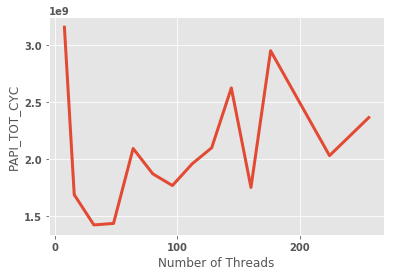

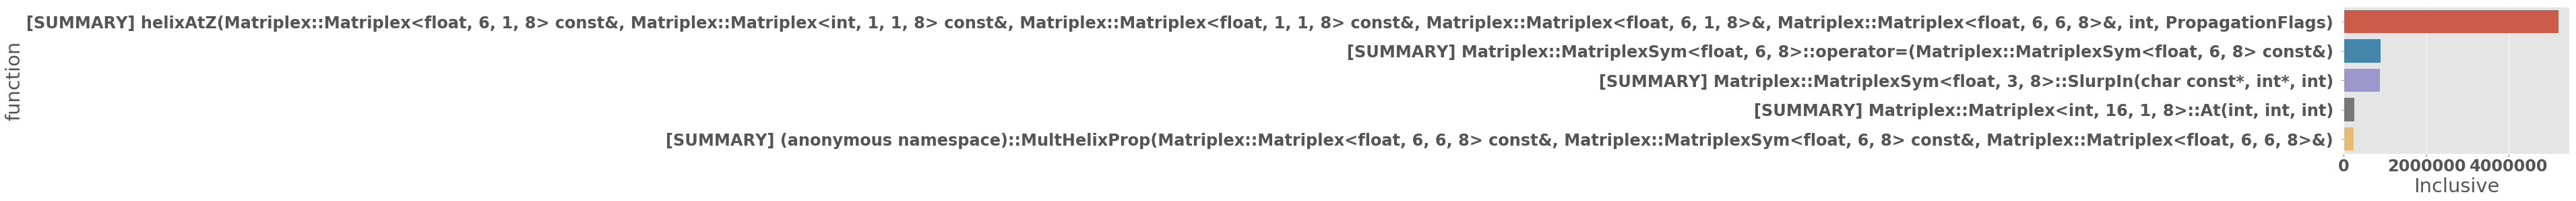

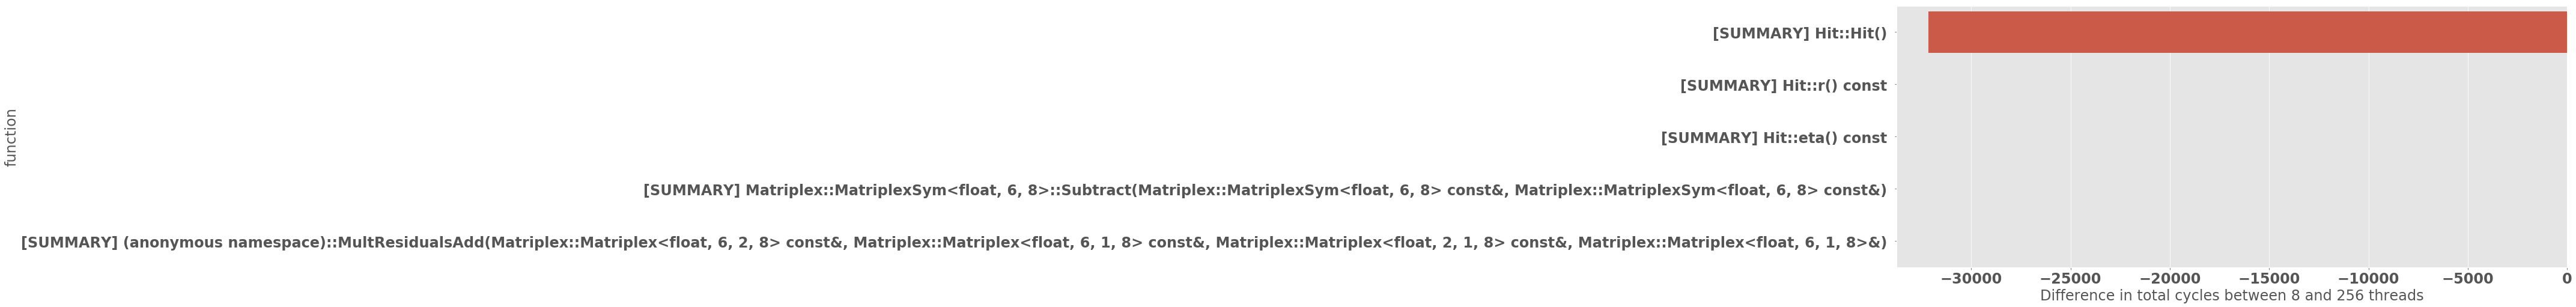

In [11]:
#thread_0 = expr_intervals['PAPI_TOT_CYC'].xs(0, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
METRIC='PAPI_TOT_CYC'

which='Inclusive'; inc = True; scaleByFractionOfTotal=True
thread_list, STL_PCT_data = scaling_plot(mdata, inclusive=inc, plot=False, metric=METRIC)
    
p = matplotlib.pyplot.plot(thread_list, STL_PCT_data,linewidth=3)
plt.xlabel('Number of Threads')
plt.ylabel(METRIC)

STL_PCT_data = select_metric_from_scaling(mdata, METRIC)

STL_PCT_dict = {}
tot_cyc = {}
for n_thr in thread_list:
    if not 'PAPI_TOT_CYC' in mdata[n_thr].keys(): continue
    mydata = combine_metrics(mdata[n_thr],inc_exc='Inclusive')
    for m in mdata[n_thr].keys():
        if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == METRIC): mydata.drop([m],axis=1,inplace=True)

    tot_cyc[n_thr] = mdata[n_thr]['PAPI_TOT_CYC'].groupby(['region']).mean()\
        .sort_values(by='Inclusive',ascending=False).query('region == "[SUMMARY] .TAU application"').head(1).iloc[0]['Inclusive']
    mydata['PERC_TOTAL'] = mydata['PAPI_TOT_CYC']/tot_cyc[n_thr]
    
    
    #if scaleByFractionOfTotal: # scaled by %total
    mydata[METRIC+'_Scaled'] = mydata[METRIC] * mydata['PERC_TOTAL'] 
    #STL_PCT_dict[n_thr] = mydata.groupby(['region']).mean().sort_values(by=['PAPI_TOT_CYC',METRIC],ascending=False).head(100)
    STL_PCT_data[n_thr] = filter_libs_out(mydata.groupby(['region']).mean())#.sort_values(by=METRIC+'_Scaled',ascending=False).head(100)
    print "Threads=",n_thr
    
    STL_PCT_dict[n_thr] = STL_PCT_data[n_thr]
    STL_PCT_dict[n_thr][which] = STL_PCT_dict[n_thr][METRIC+'_Scaled']
    highest10 = STL_PCT_dict[n_thr].sort_values(by=METRIC+'_Scaled',ascending=False)
    lowest10 = STL_PCT_dict[n_thr].sort_values(by=METRIC+'_Scaled',ascending=True)

print thread_list
#STL_PCT_dict=STL_PCT_data    

func = 'NULL';
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
dd = (STL_PCT_dict[8]-STL_PCT_dict[256])
#dd.sort_values(which, inplace=True)
#dd.drop_duplicates(subset=[which],keep='first',inplace=True)

sf = get_func_level_metric(dd, inclusive=inc, func=func, avg=False)

plt.figure() 
set_chart_font_size(24); plt.rcParams['figure.figsize']=(20,8)
sf['function'] = sf.index
sf = sf[~(sf['function'].str.contains('__GI__')|sf['function'].str.contains('_ZN9__gnu_cxx13')|
          sf['function'].str.contains('[CONTEXT]'))]
sf = sf[sf['function'].str.contains('::')]
sf = sf.sort_values(by=which,ascending=False).head(10)

#scalable_funcs.Function.apply(lambda x: x.replace('[SUMMARY] .TAU application',''))
g = sns.barplot(y='function',x=which,data=sf.head(5))

nf = dd.groupby(['region'])[[which]].sum().sort_values(by=which,ascending=True)[[which]]
plt.figure() ; set_chart_font_size(24); #plt.rcParams['figure.figsize']=(20,8)
nf['function'] = nf.index
nf = nf[~(nf['function'].str.contains('__GI__')|nf['function'].str.contains('_ZN9__gnu_cxx13')|
          nf['function'].str.contains('[CONTEXT]'))]
nf = nf[nf['function'].str.contains('::')]
nf = nf.sort_values(by=which,ascending=True).head(10)
plt.rcParams["axes.labelsize"] = 24
g = sns.barplot(y='function',x=which,data=nf.head(5))
plt.xlabel('Difference in total cycles between 8 and 256 threads')

nf[which].head(10)

<Figure size 720x576 with 0 Axes>

ERROR getting DERIVED_L3_MISSRATE for thread 256
ERROR getting DERIVED_L3_MISSRATE for thread 128
ERROR getting DERIVED_L3_MISSRATE for thread 240
ERROR getting DERIVED_L3_MISSRATE for thread 4
ERROR getting DERIVED_L3_MISSRATE for thread 112
ERROR getting DERIVED_L3_MISSRATE for thread 32
ERROR getting DERIVED_L3_MISSRATE for thread 8
ERROR getting DERIVED_L3_MISSRATE for thread 64
ERROR getting DERIVED_L3_MISSRATE for thread 144
ERROR getting DERIVED_L3_MISSRATE for thread 160
ERROR getting DERIVED_L3_MISSRATE for thread 192
ERROR getting DERIVED_L3_MISSRATE for thread 224
ERROR getting DERIVED_L3_MISSRATE for thread 96
ERROR getting DERIVED_L3_MISSRATE for thread 16
ERROR getting DERIVED_L3_MISSRATE for thread 48
ERROR getting DERIVED_L3_MISSRATE for thread 80
ERROR getting DERIVED_L3_MISSRATE for thread 176
ERROR getting DERIVED_L3_MISSRATE for thread 208


(0, 0.12)

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

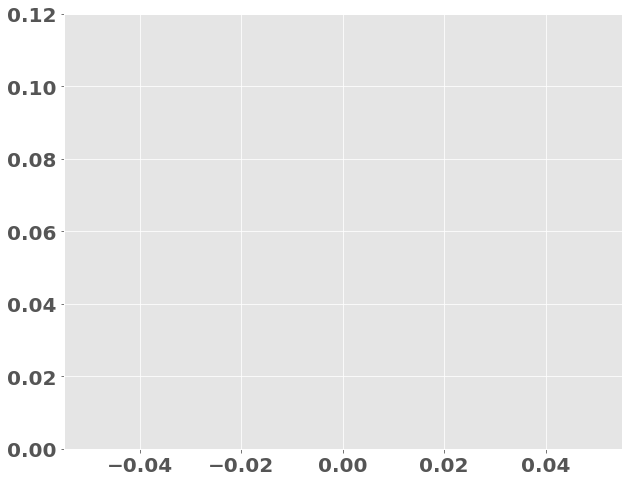

In [12]:
func = 'LayerInfo::is_within_r_sensitive_region'
#func = 'helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)'
func = 'NULL'

which='Inclusive';inc=True
matplotlib.rcParams.update({'font.size': 20})
set_chart_font_size(20);
plt.figure(figsize=(10,8))
df = pd.DataFrame()
#lines = {'DERIVED_VIPI':'yh--'}#,
lines = {'DERIVED_L1_MISSRATE':'b+-','DERIVED_L2_MISSRATE':'mx-.','DERIVED_L3_MISSRATE':'ro--','DERIVED_BRANCH_MR':'g*:'}

for METRIC, ls in lines.items():
    thread_list, data = scaling_plot(mdata, inclusive=inc, plot=False, metric=METRIC)
    p = matplotlib.pyplot.plot(thread_list, data, ls, linewidth=3, 
                               label=METRIC.replace('DERIVED_','').replace('_',' '))
    

    axes = plt.gca(); axes.set_ylim([0,0.12])
    
    axes.set_axis_bgcolor("white")
    axes.grid(linestyle=':', linewidth='0.5', color='yellow')
    leg = plt.legend(loc='upper left', ncol=2, shadow=True, fancybox=True)
    plt.xlabel('Threads')
    plt.ylabel('Miss rate')
    


    #data = select_metric_from_scaling(mdata, METRIC)
    #mdict = {}
    #for n_thr in thread_list:
    #    mdict[n_thr] = filter_libs_out(data[n_thr]).sort_values(by=which,ascending=False)[[which]]
    

In [ ]:
func = 'Matriplex::Matriplex<int, 1, 1, 8>::operator\[\]'
for func in ['MkBuilder::map_seed_hits','Hit::Hit','Matriplex::Matriplex<float, 1, 1, 8>::operator[]','MkFinder::SelectHitIndices']:
    incdata = combine_metrics(metric_data[256],inc_exc='Inclusive')
    set_chart_font_size(18);

    group_data = incdata.groupby(['region']).mean()
    #group_data.head()
    #group_data.reset_index(inplace=True)
    #group_data.head()
    #metric_list = group_data.mean().sort_values(by='PAPI_TOT_CYC',ascending=False)
    #fd = group_data[group_data['region'].str.contains(func,regex=False)]
    fd = group_data[group_data.index.get_level_values('region').str.contains(func,regex=False)]
    fd = fd.sort_values(by='PAPI_TOT_CYC',ascending=False)
    metrics1 = ['PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD', 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD','PAPI_BR_CN',
                'PAPI_BR_INS',  'PAPI_LST_INS', 'PAPI_BR_UCN','PAPI_TOT_INS']
    metrics2 = ['PAPI_NATIVE_LLC_MISSES','PAPI_BR_MSP', 'PAPI_L2_TCM', 
                 'PAPI_L1_TCM', 'PAPI_TLB_DM']

    insmix = fd.head(1)[metrics1]
    for m in metrics1: insmix[m] = insmix[m]/insmix['PAPI_TOT_INS']
    insmix = insmix.drop('PAPI_TOT_INS',axis=1)
    insmix['Other'] = 1.0 - insmix.sum(axis=1)
    insmix = insmix.T; insmix[insmix<0]=0
    insmix.insert(0, 'Metric',pd.Series(names))
    insmix.rename(columns={func:'Value'}, inplace=True)
    #insmix = insmix.reset_index()[['Metric','Value']].set_index('Metric')
    insmix

    labels= insmix['Metric'].unique()
    insmix.dropna().plot.pie(subplots=True,figsize=(10, 10),labels=labels, legend=None,
                 autopct='%1.0f%%', pctdistance=0.4, labeldistance=0.8, radius=1.2)
    #plt.legend(loc="center left", fontsize=10)
    plt.ylabel(''); plt.title(func + ": Instruction Mix")
    plt.show()
    plt.savefig(func+'_insmix.png', dpi=72,transparent=True)


    bads = fd.head(1)[metrics2].T
    #for m in metrics2: insmix[m] = insmix[m]/insmix['PAPI_TOT_INS']
    bads.insert(0, 'Metric',pd.Series(names))
    bads.rename(columns={func:'Value'}, inplace=True)
    bads

    labels= bads['Metric'].unique()
    if not bads.dropna().empty:
        bads.dropna().plot.pie(subplots=True,figsize=(10, 10),labels=labels, legend=None,
                     autopct='%1.0f%%', pctdistance=0.4, labeldistance=0.8, radius=1.2)
        #plt.legend(loc="center left", fontsize=10)
        plt.ylabel(''); plt.title(func)
        plt.show()
        plt.savefig(func+'_counters.png', dpi=72,transparent=True)

# Store Buffer Stalls
<a id='stl_sb'></a>

In [ ]:
METRIC='PAPI_NATIVE_RESOURCE_STALLS:SB'
thread_list, STL_SB_data = scaling_plot(metric_data, plot=False, metric=METRIC)
    
plt = matplotlib.pyplot.plot(thread_list, STL_SB_data)

In [ ]:
thread_STL_SB_data = get_thread_level_metric_scaling(metric_data, metric=METRIC)

for kt in thread_list:
    print kt
    data = list(thread_STL_SB_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e9)
    matplotlib.pyplot.show()

In [ ]:
STL_SB_data = select_metric_from_scaling(metric_data, METRIC)
STL_SB_dict = {}
for n_thr in thread_list:
    STL_SB_dict[n_thr] = filter_libs_out(STL_SB_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

In [ ]:
THREAD_COUNT = 8
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(STL_SB_dict[THREAD_COUNT], func=func, avg=True).head(10)

In [ ]:
stl_sb_data = copy.deepcopy(alldata)
metric = METRIC

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): stl_sb_data.drop([m],axis=1,inplace=True)

def filter_libs_out(dfs):
    dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application =>' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
    return dfs_filtered        

stl_sb_data = stl_sb_data.groupby(['region']).mean().sort_values(by='PAPI_TOT_CYC',ascending=False).head(100)
stl_sb_data = filter_libs_out(stl_sb_data)
stl_sb_data = stl_sb_data[stl_sb_data.index.get_level_values('region').str.contains('::')]
# vipidata.sort_values(by=metric,ascending=True).head(20)
stl_sb_data.head(20)

## L2 Miss Count
<a id='l2'></a>

In [ ]:
thread_list, L2_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L2_TCM_data)

In [ ]:
thread_L2_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L2_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L2_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e8)
    matplotlib.pyplot.show()

In [ ]:
L2_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L2_TCM')
L2_TCM_dict = {}
for n_thr in thread_list:
    L2_TCM_dict[n_thr] = filter_libs_out(L2_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

In [ ]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L2_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

## L3 Miss Count
<a id='l3'></a>

In [ ]:
thread_list, L3_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L3_TCM_data)

In [ ]:
thread_L3_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L3_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=2e8)
    matplotlib.pyplot.show()

In [ ]:
L3_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L3_TCM')
L3_TCM_dict = {}
for n_thr in thread_list:
    L3_TCM_dict[n_thr] = filter_libs_out(L3_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

In [ ]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L3_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

## Fetch Stalls
<a id='fetch_stalls'></a>

In [ ]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
    
# plt = matplotlib.pyplot.plot(thread_list, FETCH_STALL_data)

In [ ]:
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# for kt in thread_list:
#     print kt
#     data = list(thread_FETCH_STL_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=2e9)
#     matplotlib.pyplot.show()

In [ ]:
# FS_data = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_FETCH_STALL')
# FS_dict = {}
# for n_thr in thread_list:
#     FS_dict[n_thr] = filter_libs_out(FS_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [ ]:
# THREAD_COUNT = 1
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FS_dict[THREAD_COUNT], func=func, avg=True).head(20)

## Stalls per Cycle
<a id='fetch_ratio'></a>

In [ ]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
# thread_list, TOT_CYC_data = scaling_plot(metric_data, plot=False, metric='PAPI_TOT_CYC')
    
# FS_P_CYC_list = [FETCH_STALL_data[i] / TOT_CYC_data[i] for i in range(len(thread_list))]

# plt = matplotlib.pyplot.plot(thread_list, FS_P_CYC_list)

In [ ]:
# thread_TOT_CYC_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# FS_P_CYC_data = {}
# for kt in thread_list:
# #     print(thread_L1M_data[kt])
# #     print(thread_L1A_data[kt])
#     FS_P_CYC_data[kt] = thread_FETCH_STL_data[kt] / thread_TOT_CYC_data[kt]
     
# for kt in thread_list:
#     print kt
#     data = list(FS_P_CYC_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=0.2)
#     matplotlib.pyplot.show()

In [ ]:
# FSTC_data = select_metric_from_scaling(metric_data, 'DERIVED_RATIO_FETCH_STL_TOT_CYC')
# FSTC_dict = {}


# def filter_libs_out_2(dfs):
#     dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application ' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
#     return dfs_filtered

# for n_thr in thread_list:
#     FSTC_dict[n_thr] = filter_libs_out_2(FSTC_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# #     FSTC_dict[n_thr] = FSTC_data[n_thr].sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [ ]:
# THREAD_COUNT = 32
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(10)